# Car Racing


## ***Step 1:*** Install libraries

In [1]:
# @title установка драйверов
!apt-get update > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get install -y swig build-essential python-dev python3-dev > /dev/null 2>&1
!apt-get install x11-utils > /dev/null 2>&1
!apt-get install xvfb > /dev/null 2>&1

In [2]:
# @title установка библиотек
%%capture
!pip install rarfile --quiet
!pip install stable-baselines3[extra] --quiet
!pip install ale-py --quiet
!pip install gym[box2d] --quiet
!pip install pyvirtualdisplay --quiet
!pip install pyglet --quiet
!pip install pygame --quiet
!pip install minigrid --quiet
!pip install -q swig --quiet
!pip install -q gymnasium[box2d] --quiet
!pip install 'minigrid<=2.1.1' --quiet
!pip3 install box2d-py --quiet


## ***Step 2:*** Import useful libraries

In [3]:
# Imports
import io
import os
import glob
import torch
import base64

import numpy as np
import matplotlib.pyplot as plt

import sys
import gymnasium
sys.modules["gym"] = gymnasium

import stable_baselines3
from stable_baselines3.common.results_plotter import ts2xy, load_results
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3 import DDPG

import gymnasium as gym
from gym import spaces
from gym.wrappers import RecordVideo

In [ ]:
# !git clone https://github.com/AGiannoutsos/car_racer_gym.git
# %cd car_racer_gym

# from car_racing import CarRacingDiscrete, CarRacing

In [4]:
# @title Вспомогательная функция вывода в виртуальный дисплей
from IPython.display import HTML
from base64 import b64encode
from pyvirtualdisplay import Display

# create the directory to store the video(s)
os.makedirs("./video", exist_ok=True)

display = Display(visible=False, size=(1400, 900))
_ = display.start()

"""
Функция позволяет записывать видео из gym и отображать его.
Чтобы включить видео, просто выполните "env = wrap_env(env)""
"""
def render_mp4(videopath: str) -> str:
  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  return f'<video width=400 controls><source src="data:video/mp4;' \
         f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'

## ***Step 3:*** Create video end educate model



In [5]:
import gymnasium as gym
env = gym.make(
    "CarRacing-v3"
)

In [6]:
observation, info = env.reset()

for _ in range(1000):
    action = env.action_space.sample()  # agent policy that uses the observation and info
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        observation, info = env.reset()

env.close()
print(reward)

-0.10000000000000142


In [7]:
"""
Ornstein-Uhlenbeck noise implemented by OpenAI
Copied from https://github.com/openai/baselines/blob/master/baselines/ddpg/noise.py
"""
class OrnsteinUhlenbeckActionNoise:
    def __init__(self, mu, sigma, theta=.15, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
            self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

ou_action_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(1), sigma=np.ones(1) * 0.05)


In [24]:
from stable_baselines3 import DDPG
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv

log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

# Имя среды
env_name = 'CarRacing-v3'
env = gym.make(env_name)

# Обернуть среду в Monitor для логирования
env = Monitor(env, log_dir)

# Окружающая среда должна быть векторизована
env = DummyVecEnv([lambda: env])

# Создаем шумы для исследования действий (action noise)
n_actions = env.action_space.shape[0]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

# Конфигурация нейронной сети
policy_kwargs = dict(
    features_extractor_kwargs=dict(features_dim=256),  # Размер выходного слоя после CNN
    activation_fn=torch.nn.ReLU,
    net_arch=[256, 256]
)

# Создаем модель DDPG
model = DDPG(
    "CnnPolicy",
    env,
    action_noise=ou_action_noise,
    policy_kwargs=policy_kwargs,
    verbose=1,
    tensorboard_log=log_dir
)

# Callbacks для периодической оценки
eval_env = gym.make(env_name)
eval_env = Monitor(eval_env, log_dir)
eval_callback = EvalCallback(eval_env, best_model_save_path=log_dir, log_path=log_dir, eval_freq=5000)

# Обучение модели
model.learn(total_timesteps=150000, callback=eval_callback, log_interval=1)

# Сохранение модели
model.save(log_dir + "ddpg_car_racing")

# Загрузка модели для тестирования
loaded_model = DDPG.load(log_dir + "best_model", env=env)


Using cuda device
Wrapping the env in a VecTransposeImage.


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 55.32GB > 0.74GB
  warnings.warn(


Logging to /tmp/gym/DDPG_2


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/callbacks.py:418: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.vec_transpose.VecTransposeImage object at 0x7b2e04b0c580> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7b2e04b0ed40>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


KeyboardInterrupt: 

In [25]:
loaded_model = DDPG.load(log_dir + "best_model", env=env)

Wrapping the env in a VecTransposeImage.


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 55.32GB > 0.78GB
  warnings.warn(


In [28]:
from tqdm import tqdm
env = gym.make(env_name, render_mode="rgb_array")
env = RecordVideo(env, video_folder=f"video/{env_name}_pretraining", episode_trigger=lambda episode_id: True)
observation = env.reset()[0]

total_reward = 0
done = False
for i in tqdm(range(1000)):
  frame = env.render()
  action, states = loaded_model.predict(observation)
  observation, reward, done, info, _ = env.step(action)
  total_reward += reward
env.close()
print(f"\nTotal reward: {total_reward}")

# show video
html = render_mp4(f"video/{env_name}_pretraining/rl-video-episode-0.mp4")
HTML(html)

100%|██████████| 1000/1000 [00:56<00:00, 17.78it/s]



Total reward: -93.80804953560265


In [29]:
model = DDPG(
    "CnnPolicy",
    env,
    action_noise=ou_action_noise,
    policy_kwargs=policy_kwargs,
    verbose=1,
    tensorboard_log=log_dir
)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 55.32GB > 0.77GB
  warnings.warn(


## ***Step 4:*** Check uneducate model


In [30]:
from tqdm import tqdm
env = gym.make(env_name, render_mode="rgb_array")
env = RecordVideo(env, video_folder=f"video/{env_name}_pretraining", episode_trigger=lambda episode_id: True)
observation = env.reset()[0]

total_reward = 0
done = False
for i in tqdm(range(1000)):
  frame = env.render()
  action, states = model.predict(observation, deterministic=True)
  observation, reward, done, info, _ = env.step(action)
  total_reward += reward
env.close()
print(f"\nTotal reward: {total_reward}")

# show video
html = render_mp4(f"video/{env_name}_pretraining/rl-video-episode-0.mp4")
HTML(html)

100%|██████████| 1000/1000 [00:56<00:00, 17.68it/s]



Total reward: -23.076923076922892


In [18]:
import pandas as pd
monitor_data = pd.read_excel(os.path.join(log_dir, "monitor_clear.xlsx"), skipfooter=1)
reward_records = monitor_data['r'].tolist()

In [21]:
np.argmax(np.array(reward_records))

104

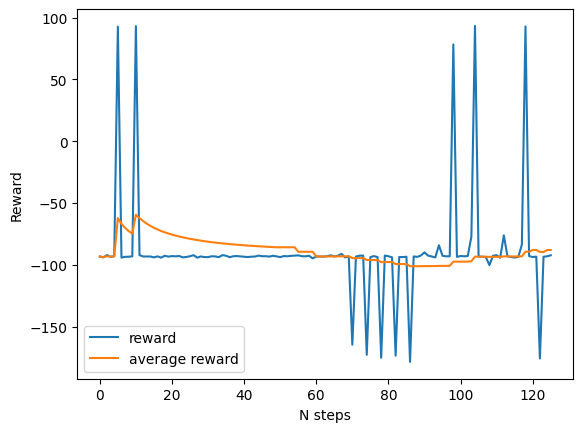

In [19]:
import matplotlib.pyplot as plt
# Generate recent 50 interval average
average_reward = []
for idx in range(len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 50:
        avg_list = reward_records[:idx+1]
    else:
        avg_list = reward_records[idx-49:idx+1]
    average_reward.append(np.average(avg_list))
plt.plot(reward_records, label='reward')
plt.plot(average_reward, label='average reward')
plt.xlabel('N steps')
plt.ylabel('Reward')
plt.legend()
plt.show()